In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'
df = pd.read_csv(url)
print(df.head)

<bound method NDFrame.head of      Unnamed: 0     id                domain        type  \
0             0    141               awm.com  unreliable   
1             1    256     beforeitsnews.com        fake   
2             2    700           cnnnext.com  unreliable   
3             3    768               awm.com  unreliable   
4             4    791  bipartisanreport.com   clickbait   
..          ...    ...                   ...         ...   
245         245  39259     beforeitsnews.com        fake   
246         246  39468     beforeitsnews.com        fake   
247         247  39477       www.newsmax.com         NaN   
248         248  39550       www.newsmax.com         NaN   
249         249  39558       www.newsmax.com         NaN   

                                                   url  \
0    http://awm.com/church-congregation-brings-gift...   
1    http://beforeitsnews.com/awakening-start-here/...   
2    http://www.cnnnext.com/video/18526/never-hike-...   
3    http://awm.c

Top 10 words in tokenized sample: [('<num>', 2558), ('one', 444), ('people', 386), ('trump', 347), ('like', 328), ('would', 323), ('time', 303), ('us', 284), ('also', 276), ('new', 270)]
Top 10 words in original sample: [('the', 9379), ('of', 4943), ('to', 4841), ('and', 4643), ('a', 3317), ('in', 3064), ('is', 2262), ('that', 2109), ('for', 1528), ('are', 1210)]
Top 10 words in stemmed sample: [('<num>', 2558), ('one', 468), ('like', 407), ('time', 405), ('peopl', 389), ('state', 370), ('trump', 350), ('would', 323), ('use', 323), ('market', 298)]
Number of URLs: 209
Number of dates: 0
Number of numerics: 2558


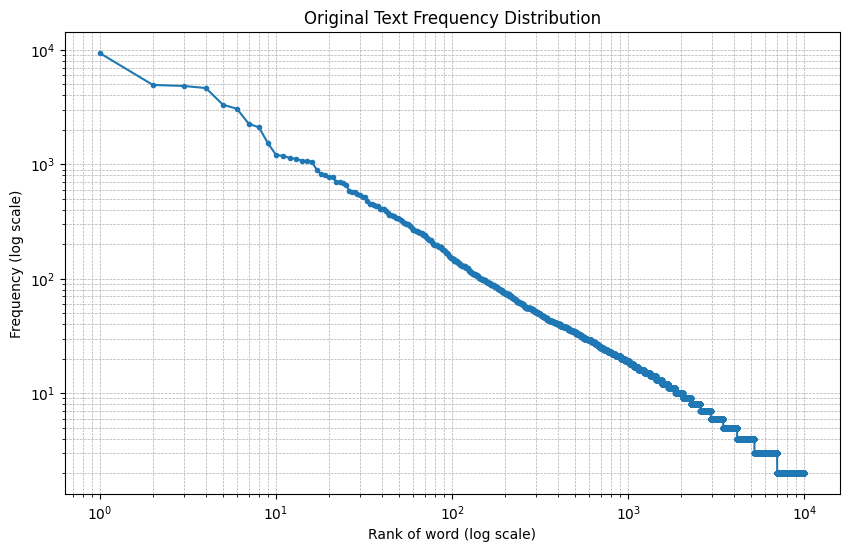

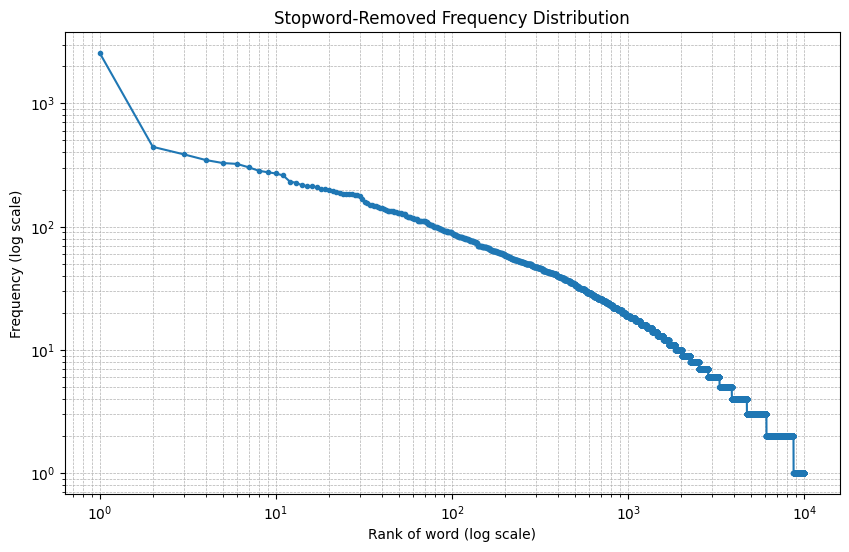

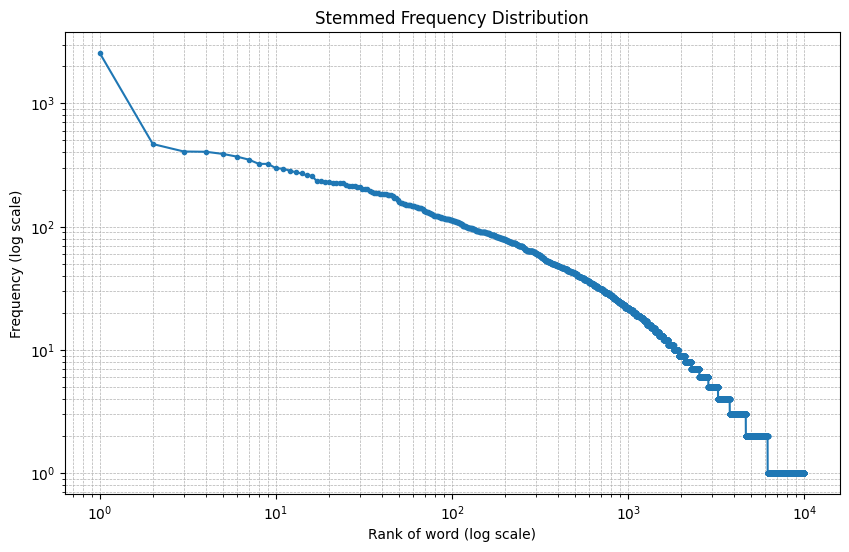

In [7]:
import re
import pandas as pd
from collections import Counter
from itertools import chain
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

def plot_word_frequency(counter, top_n=10000, title="Word Frequency Distribution"):
    """
    Plots the frequency distribution of the top_n words using a log-log plot.
    """
    # Extract frequencies of the most common words
    freqs = [freq for word, freq in counter.most_common(top_n)]
    
    plt.figure(figsize=(10, 6))
    plt.loglog(range(1, len(freqs) + 1), freqs, marker=".")
    plt.xlabel("Rank of word (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


# Regex pattern for tokenization
# <\w+> matches tags (e.g., <num>), [\w]+(?:-[\w]+)? matches words with hyphens
pattern = r"<\w+>|[\w]+(?:-[\w]+)?"
tokenizer = RegexpTokenizer(pattern)

def clean_text(text: str) -> str:
    """
    Cleans a text string by replacing dates, emails, URLs, and numbers with placeholder tokens.
    """
    # Replace dates (formats: YYYY-MM-DD and DD-MM-YYYY)
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', '<DATE>', text)
    text = re.sub(r'\b\d{2}-\d{2}-\d{4}\b', '<DATE>', text)
    # Replace email addresses
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '<EMAIL>', text)
    # Replace URLs (http/https)
    text = re.sub(r'https?://\S+', '<URL>', text)
    # Replace numbers (including decimals)
    text = re.sub(r'\b\d+(\.\d+)?\b', '<NUM>', text)
    
    return text.strip().lower()

def tokenize_text(text: str, stop_words: set) -> list:
    """
    Tokenizes the input text using NLTK and removes stopwords.
    """
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in stop_words]

def stem_tokens(tokens: list) -> list:
    """
    Applies Porter stemming to a list of tokens.
    """
    ps = PorterStemmer()
    return [ps.stem(token) for token in tokens]

def main(df, text_column: str = 'content'):
    # Ensure we work with the target text column only
    df[text_column] = df[text_column].astype(str)
    
    # Define English stopwords set
    stop_words = set(stopwords.words('english'))
    
    # Clean and tokenize the specified text column
    tokenized_series = df[text_column].apply(lambda x: " ".join(tokenize_text(clean_text(x), stop_words)))
    tokenized_series.to_csv("block_stopwords_news_sample.csv", index=False)
    
    # Count word frequencies in the tokenized text
    all_tokens = list(chain.from_iterable(tokenized_series.str.split()))
    token_freq = Counter(all_tokens)
    
    # Count word frequencies in the original (lowercased) text for comparison
    original_tokens = list(chain.from_iterable(df[text_column].str.lower().str.split()))
    original_freq = Counter(original_tokens)
    
    print(f"Top 10 words in tokenized sample: {token_freq.most_common(10)}")
    print(f"Top 10 words in original sample: {original_freq.most_common(10)}")
    
    # Apply stemming to the tokenized text
    stemmed_series = tokenized_series.apply(lambda x: " ".join(stem_tokens(x.split())))
    stemmed_series.to_csv("stemmed_news_sample.csv", index=False)
    
    # Count word frequencies in the stemmed text
    all_stemmed_tokens = list(chain.from_iterable(stemmed_series.str.split()))
    stem_freq = Counter(all_stemmed_tokens)
    print(f"Top 10 words in stemmed sample: {stem_freq.most_common(10)}")
    
    # Use vectorized string methods to count the placeholder tokens
    url_count = stemmed_series.str.count("<url>").sum()
    date_count = stemmed_series.str.count("<date>").sum()
    num_count = stemmed_series.str.count("<num>").sum()
    
    print(f"Number of URLs: {url_count}")
    print(f"Number of dates: {date_count}")
    print(f"Number of numerics: {num_count}")
    plot_word_frequency(original_freq, top_n=10000, title="Original Text Frequency Distribution")
    plot_word_frequency(token_freq, top_n=10000, title="Stopword-Removed Frequency Distribution")
    plot_word_frequency(stem_freq, top_n=10000, title="Stemmed Frequency Distribution")


# Read the CSV file into a DataFrame and select a subset (for testing)
df = pd.read_csv("Datasets/news_sample.csv", encoding="utf-8")
df_sample = df.head(300)  # For a large dataset, consider processing in chunks
main(df_sample, text_column='content')


We're using Pandas and NLTK because Pandas offers a robust data handling and cleaning capabilities, which is essential for large datasets. While NLTK Provides a suite of NLP tools (tokenization, stopwords, stemming) that are standard in text preprocessing. These operations help normalize the data for downstream analysis and modeling.

Pandas DataFrame: It’s flexible, easy to filter and analyze, and supports integration with visualization libraries.
Rationale: A DataFrame structure is ideal for handling large datasets and performing exploratory data analysis (EDA).


Applying my data pipeline to the 995000 rows sample

C:\Users\nikla\AppData\Local\Temp\ipykernel_7620\1377924867.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


Top 10 words in tokenized sample: [('<num>', 4162), ('said', 494), ('one', 364), ('new', 330), ('people', 326), ('would', 295), ('mr', 233), ('also', 227), ('trump', 222), ('state', 195)]
Top 10 words in original sample: [('the', 8624), ('of', 4322), ('to', 4098), ('and', 3681), ('a', 3309), ('in', 2827), ('that', 1767), ('is', 1510), ('for', 1386), ('on', 1099)]
Top 10 words in stemmed sample: [('<num>', 4162), ('said', 494), ('one', 387), ('state', 385), ('time', 332), ('peopl', 331), ('new', 330), ('would', 295), ('year', 267), ('like', 238)]
Number of URLs: 60
Number of dates: 2
Number of numerics: 4162


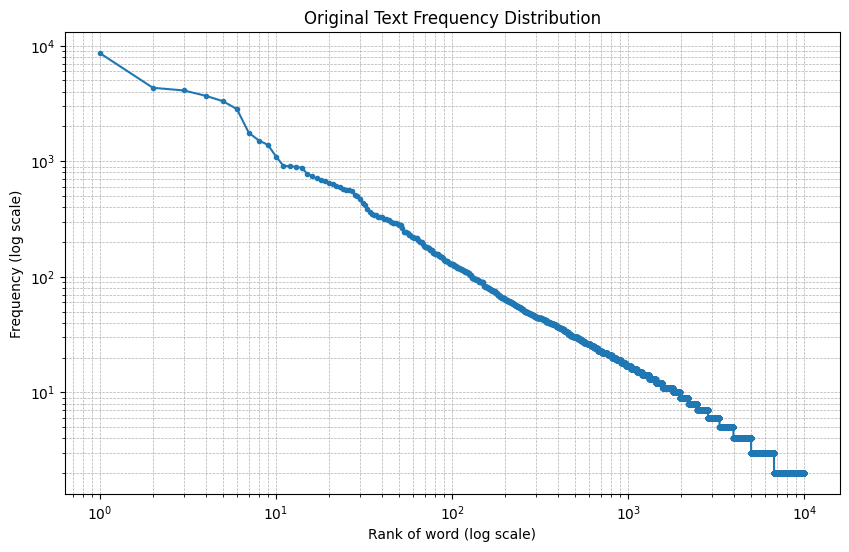

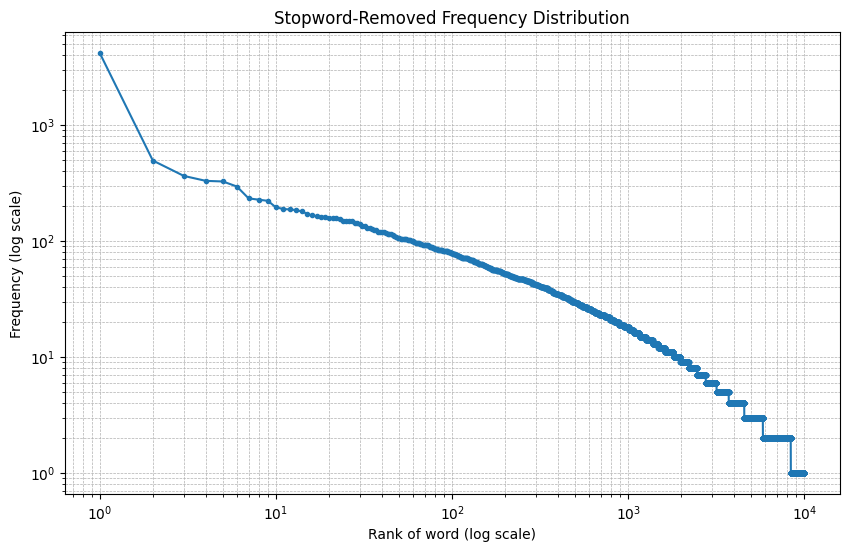

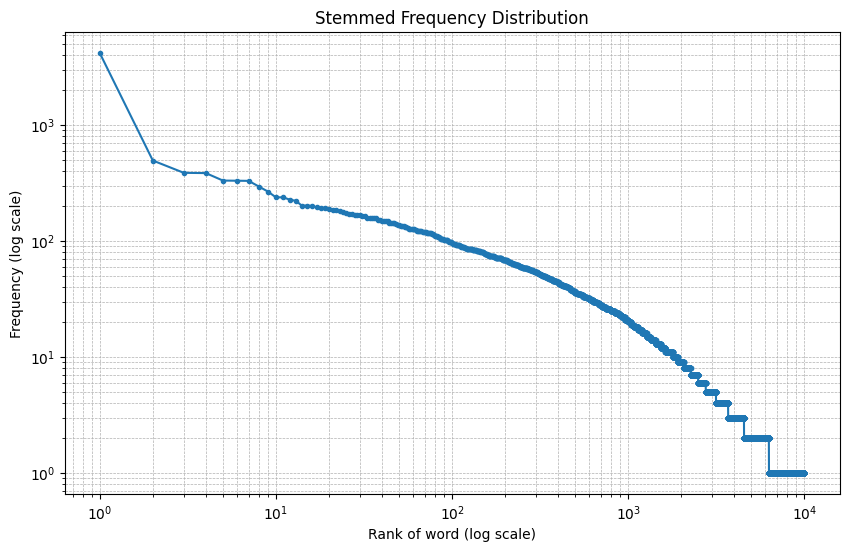

In [8]:
subsetSample = pd.read_csv("Datasets\\995000_rows.csv", encoding="utf-8", low_memory=False)

main(subsetSample.head(300), text_column='content')


The columns (0,1) have mixed types?
